_Neural Data Science_

Lecturer: Dr. Jan Lause, Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Julius Würzler

Summer term 2025

Student names: <span style='background: yellow'>*Akseli Ilmanen, * </span>

LLM Disclaimer: <span style='background: yellow'>*Did you use an LLM to solve this exercise? If yes, which one and where did you use it? [Copilot, Claude, ChatGPT, etc.]* </span>

# Coding Lab 1

## Introduction

In this coding lab you get to implement a pipeline for spike detection and feature extraction, as presented in the lecture:
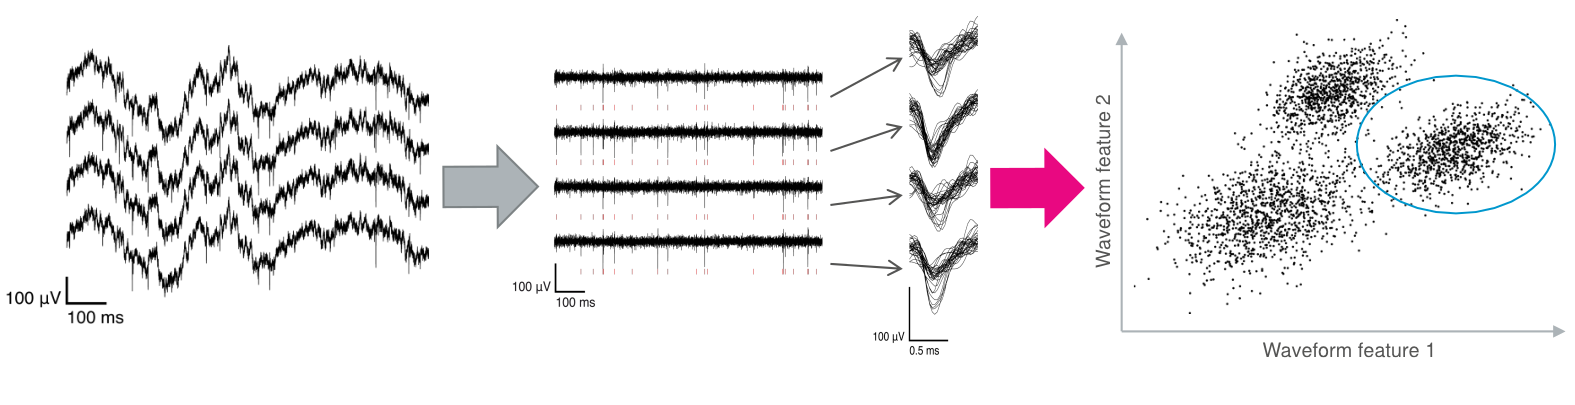

This will later be used for spike sorting (identifying which spike / waveform in the signal was caused by which neuron).

The data used in this notebook was recorded at 30kHz with a tetrode and thus contains the voltage traces of the 4 channels in μV.

_(for more information on the data acquisition, you can have a look at [Ecker et al 2014](https://doi.org/10.1016/j.neuron.2014.02.006), in particular the supplementary material. A similar pipeline is also used in [Ecker et al 2010](https://doi.org/10.1126/science.1179867). Note however that we only use a small portion of the data in this notebook and most of the experiment setup is not relevant here!)_

## Setup
- __Data__: Download the data file ```nds_cl_1.csv``` from ILIAS and save it in a subfolder ```../data/```.
- __Dependencies__: You don't have to use the exact versions of all the dependencies in this notebook, as long as they are new enough. But if you run "Run All" in Jupyter and the boilerplate code breaks, you probably need to upgrade them.


Recommended folder structure:

```
.
├── data/
│   └── nds_cl_1.csv
├── notebooks
│   └── CodingLab1.ipynb
├── matplotlib_style.txt
└── requirements.txt
```

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.decomposition import PCA
from __future__ import annotations  # for Python 3.8 and below

# black is a code formatter (see https://github.com/psf/black).
# It will automatically format the code you write in the cells imposing consistent Python style.
%load_ext jupyter_black

%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark -p sklearn

Last updated: 2025-04-21 15:22:07W. Europe Summer Time

Python implementation: CPython
Python version       : 3.10.0
IPython version      : 8.35.0

sklearn: 1.6.1

pandas    : 2.2.3
sklearn   : 1.6.1
numpy     : 2.2.4
scipy     : 1.15.2
matplotlib: 3.10.1

Watermark: 2.5.0



In [3]:
# matplotlib style file
# Template for style file: https://matplotlib.org/stable/tutorials/introductory/customizing.html#customizing-with-style-sheets
plt.style.use("../matplotlib_style.txt")

## Load data

In [4]:
import os

fs = 30000.0  # sampling rate of the signal in Hz
dt = 1 / fs
cols = ["Ch1", "Ch2", "Ch3", "Ch4"]


x = pd.read_csv("../data/nds_cl_1.csv", header=0, names=cols)

In [5]:
x.describe()

,Ch1,Ch2,Ch3,Ch4
count,1.920000e+07,1.920000e+07,1.920000e+07,1.920000e+07
mean,3.600331e+00,-8.850918e-01,2.864284e-01,2.210982e+00
std,5.824474e+02,6.014818e+02,6.464363e+02,6.126105e+02
min,-3.607000e+03,-3.739000e+03,-3.871000e+03,-3.750000e+03
25%,-3.460000e+02,-3.610000e+02,-3.950000e+02,-3.640000e+02
50%,1.200000e+01,8.000000e+00,-1.000000e+00,1.000000e+01
75%,3.650000e+02,3.720000e+02,4.010000e+02,3.810000e+02
max,2.873000e+03,3.004000e+03,3.099000e+03,3.017000e+03


## Task 1: Filter Signal

In order to detect action potentials, the first step is to filter out low frequency fluctuations (LFP) and high frequency noise. Determine appropriate filter settings and implement the filtering in the function ```filter_signal()```. A typical choice for this task would be a <mark>butterworth filter</mark>.

Plot a segment of the raw signal and the filtered signal for all four channels with matching y-axis. The segment you choose should contain spikes. When you apply the function also test different filter settings.

*Grading: 3 pts*


In [6]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [7]:
## Current Best Practice
def filter_signal(
    x: pd.DataFrame, fs: float, low: float, high: float, order: int = 3, plot=False
) -> pd.DataFrame:
    """Filter raw signal x.

    Parameters
    ----------

    x: pd.DataFrame, (n_samples, n_channels)
        Each column in x is one recording channel.

    fs: float
        Sampling frequency.

    low, high: float, float
        Passband in Hz for the butterworth filter.

    order: int
        The order of the Butterworth filter. Default is 3, but you should try
        changing this and see how it affects the results.


    Returns
    -------

    y: pd.DataFrame, (n_samples, n_channels)
        The filtered x. The filter delay is compensated in the output y.


    Notes
    ----

    1. Try exploring different filters and filter settings. More info:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

    2. The output signal should be phase-shift compensated. More info:
    https://dsp.stackexchange.com/a/19086

    """

    # -----------------------------------------------------------------
    # implement a suitable filter and apply it to the input data (1pt)

    # convert from df to np array

    x_np = x.to_numpy()

    # convert cufoff frequency to normalized frequency
    nyquist = fs / 2.0  # Nyquist frequency
    low = low / nyquist  # normalized low frequency
    high = high / nyquist  # normalized high frequency

    print(low, high)

    # band pass filter
    b, a = signal.butter(order, [low, high], "bandpass")

    if plot:
        # Plot frequency response for digital filter
        w, h = signal.freqz(b, a, worN=8000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), "b")
        plt.title("Butterworth filter frequency response")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Gain")
        plt.grid()
        plt.show()

    # Apply the filter to each channel
    y = np.zeros_like(x_np)
    for i in range(x.shape[1]):
        y[:, i] = signal.filtfilt(b, a, x_np[:, i])

    # np array to pd dataframe
    y = pd.DataFrame(y, columns=x.columns)

    # -----------------------------------------------------------------

    return y

0.06666666666666667 0.3333333333333333


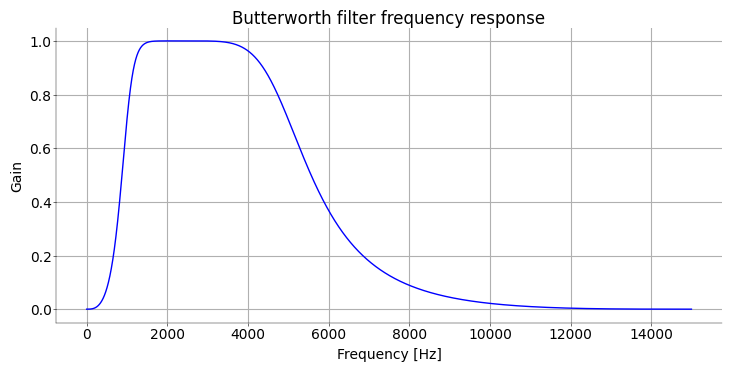

In [8]:
cutoff_low = 1000  # low cutoff frequency in Hz
cutoff_high = 5000  # high cutoff frequency in Hz
order = 3  # order of the filter

y = filter_signal(x, fs, cutoff_low, cutoff_high, order, plot=True)

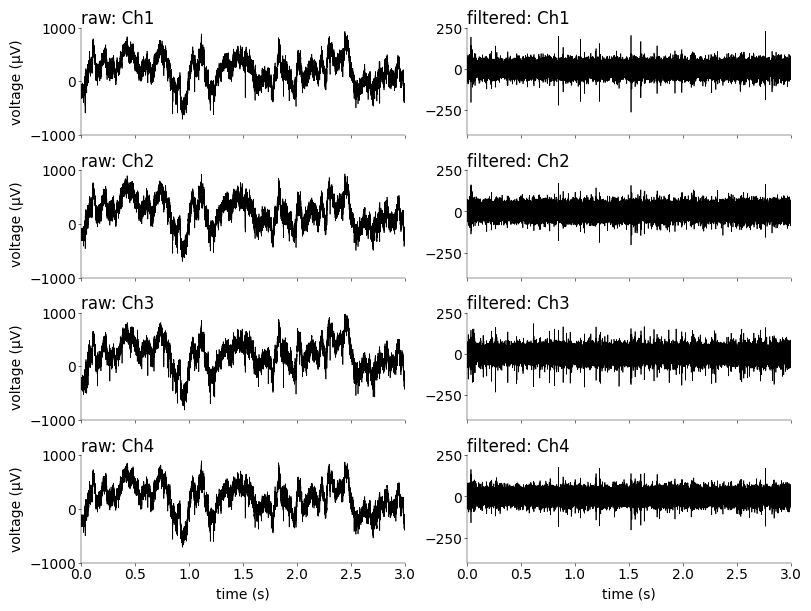

In [9]:
mosaic = [
    ["raw: Ch1", "filtered: Ch1"],
    ["raw: Ch2", "filtered: Ch2"],
    ["raw: Ch3", "filtered: Ch3"],
    ["raw: Ch4", "filtered: Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

T = 100000
t = np.arange(0, T) * dt

# ------------------------------------------------------------------------------------
# Plot raw and filtered signals for all 4 channels and answer the questions (1+1 pts)

for i, (raw, filtered) in enumerate(mosaic):
    # Plot raw signal
    ax[raw].plot(t, x[f"Ch{i+1}"][:T], color="black", lw=0.5, label=raw)
    # Plot filtered signal
    ax[filtered].plot(t, y[f"Ch{i+1}"][:T], color="black", lw=0.5, label=filtered)

# ------------------------------------------------------------------------------------


for i, (raw, filtered) in enumerate(mosaic):
    ax[raw].set_xlim((0, 3))
    ax[raw].set_ylim((-1000, 1000))

    ax[filtered].set_xlim((0, 3))
    ax[filtered].set_ylim((-400, 250))

    # Add labels and title
    ax[raw].set_ylabel("voltage (μV)")
    ax[raw].set_title(raw, loc="left")
    ax[filtered].set_title(filtered, loc="left")
    if i != 3:
        ax[raw].set_xticklabels([])
        ax[filtered].set_xticklabels([])
    else:
        ax[raw].set_xlabel("time (s)")
        ax[filtered].set_xlabel("time (s)")

### Questions
1) Explain your implementation: Which filter and parameters did you choose and why?

- Order 3 step -> fast roll-off in frequency response (see `plot=true`), cutoff 500-5000Hz -> typical bandpass in ephys extracellular recordings. In `scipy.signal.butter`, first I had a `analog=true` but this caused `y` to be very small. Maybe for analog filters, one would also require an amplifier? Therefore, I used a digital filer.

2) Which parameters of the function can be adjusted, which are determined by the experiment setup? What is the effect of the adjustable parameters?

- Sampling frequency determined by experimental set-up. Adjustble parameters -> see answer 1). 

3) How does the filtered signal look compared to the original? Why is this helpful as preprocessing in our spike detection pipeline?

- Remove low frequency fluctuations (background population activity) & high-frequency electric/biological noise.

## Task 2: Detect action potentials

Action potentials are usually detected by finding large-amplitude deflections in the continuous signal. A good choice of threshold for detecting spikes is important. If it is too low, you will detect too many low amplitude events (noise); if it is too high, you run the risk of missing good spikes. Implement an automatic procedure to obtain a reasonable threshold and detect the times when spikes occurred in the function ```detect_spikes()```.

Plot a segment of the filtered signal for all four channels with matching y-axis and indicate the time points where you detected spikes, also **plot the threshold**.

*Grading: 4 pts*

In [10]:
from scipy.stats import median_abs_deviation
from scipy.signal import find_peaks


def detect_spikes(
    x: np.ndarray, fs: float, N: int = 5, lockout: float = 1.0
) -> tuple[np.ndarray, np.ndarray, np.float64]:
    """Detect spikes in the signal x and compute a threshold.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal from Task 1.

    fs: float
        the sampling rate (in Hz).

    N: int
        An arbitrary number with which you multiply with the standard deviation
        to set a threshold that controls your false positive rate. Default is 5
        but you should try changing it and see how it affects the results.

    lockout: float
        a window of 'refractory period', within which there's only one spike.
        Default is 1ms but you should also try changing it.


    Returns
    -------

    s: np.array, (n_spikes, )
        Spike location / index in the signal x.

    st: np.array, (n_spikes, )
        Spike time in ms. By convention the time of the zeroth sample is 0 ms.

    thrd: float
        Threshold = -N * sigma.


    Tips
    ----

    You can use scipy functions like find_peaks for the detection.
    Note: There are four channels in signal x.

    """
    # --------------------------------------------------------------
    # compute the robust s.d. and calculate the threshold (0.5 pts)

    # axis=0 -> over columns (channels)
    # formulae from class
    robust_stds = median_abs_deviation(x, axis=0) / 0.6745

    thresholds = N * robust_stds

    # We are assuming a larger negative deflection than positive deflection in spike waveform, therefore setting negative threshold
    # TLDR: We need to find troughs not peaks
    thresholds = -thresholds

    # --------------------------------------------------------------

    # --------------------------
    # find all spikes (1.5 pts)

    # To find troughs, we invert the data and find peaks on the inverted signal
    x = -x

    # Spike times (index)
    s = []
    for i in range(x.shape[1]):
        s_temp = find_peaks(x[:, i], height=-thresholds[i])[0]
        s = np.concatenate((s, s_temp))

    # there will be duplicates as spikes may be detected in multiple channels
    s = np.unique(s)

    # Convert lockout (ms -> s -> samples)
    lockout = int(lockout / 1000 * fs)

    # Remove spikes within the refactory period
    s = np.sort(s)
    differences = np.abs(np.diff(s))
    mask = differences >= lockout
    s = s[np.insert(mask, 0, True)]

    # Spikes times (seconds)
    st = s / fs

    # --------------------------

    return s, st, thresholds

In [11]:
# I renamed t -> to st (for spikes times), so there is no confusion with the time vector t
s, st, thresholds = detect_spikes(y.to_numpy(), fs, N=3.5, lockout=1)

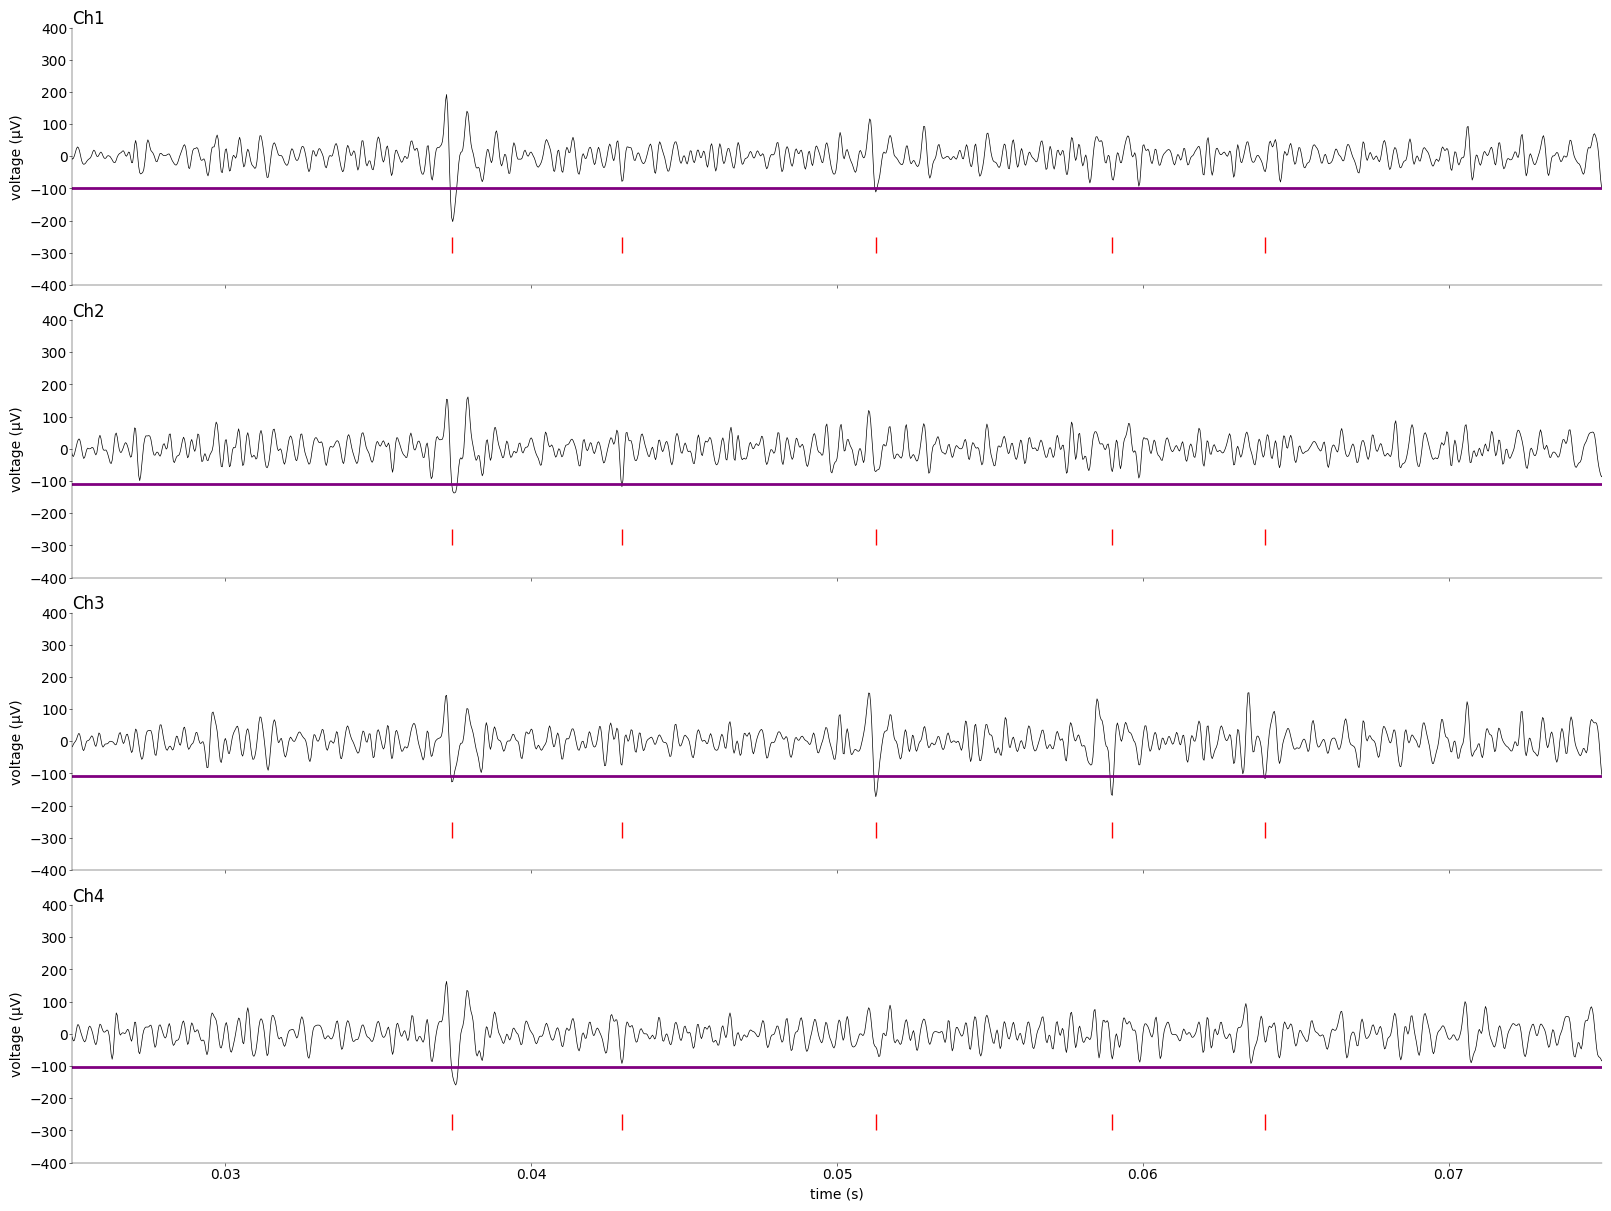

In [12]:
mosaic = [
    ["Ch1"],
    ["Ch2"],
    ["Ch3"],
    ["Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(16, 12), layout="constrained", dpi=100
)

T = 100000
t = np.arange(0, T) * dt


# ------------------------------------------------------------------------------------
# Plot raw and filtered signals for all 4 channels and answer the questions (1+1 pts)

for i, ch in enumerate(mosaic):
    ch = ch[0]

    # Plot filtered signal
    ax[ch].plot(t, y[f"Ch{i+1}"][:T], color="black", lw=0.5, label=ch)

    # Plot threshold
    ax[ch].axhline(thresholds[i], color="purple", lw=2, label="threshold")

    # Plot spikes
    ax[ch].vlines(st[:T], ymin=-250, ymax=-300, color="red", lw=1, label="spikes")
# ------------------------------------------------------------------------------

for i, col in enumerate(cols):

    ax[col].set_ylim((-400, 400))
    ax[col].set_xlim((0.025, 0.075))
    ax[col].set_ylabel("voltage (μV)")

    ax[col].set_title(col, loc="left")

    if col != "Ch4":
        ax[col].set_xticklabels([])
    else:
        ax[col].set_xlabel("time (s)")

### Questions

1) Are the detected time points well aligned with prominent extrema in the signal? Also compare your detections across channels.

The waveforms looks very similar across channels, although for some low amplitude spikes, not all channels would detect the spike

2) Take one feature of the spikes and explain how that can help us identifying the source neuron of a spike (only based on visual examination of the plot).

We can see that more waveform troughs cross the threshold in channel 3. Likely a single neuron, or maybe even multiple neuron somas are more close to the channel 3 contact.

## Task 3: Extract waveforms
For later spike sorting we need the waveforms of all detected spikes. Extract the waveforms segments (1 ms) on all four channels for each spike time (as a result each spike is represented by a 4x30 element matrix). Implement this procedure in the function ```extract_waveforms()```.

Plot (a) the first 100 spikes you detected and (b) the 100 largest spikes you detected.
Are there a lot of very small spikes (likely noise) among your detected spikes? If so your threshold may be too low. Can you see obvious artifacts, not looking like spikes at all?

*Grading: 3 pts*

In [13]:
def extract_waveforms(x: np.ndarray, s: np.ndarray) -> np.ndarray:
    """Extract spike waveforms at times s (given in samples)
    from the filtered signal `xf` using a fixed window around the
    times of the spikes.

    Parameters
    ----------

    x: np.array (n_samples, n_channels)
        The filtered signal.

    s: np.array, (n_spikes, )
        Spike time in samples.


    Return
    ------

    w: np.array, (n_spikes, length_window, n_channels)
        Waveforms. (You don't have to get the exact same
        shape as we noted here. It's just the shape of w
        that can be easily retrieved via broadcasting.)


    Notes
    -----

    More on Numpy Broadcasting
    https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html

    """
    # -------------------------------
    # extract spike waveforms (1 pt)

    window_size = int(0.001 * fs)  # 1ms window
    half_window = window_size // 2
    n_spikes = s.shape[0]
    n_channels = x.shape[1]

    w = np.zeros((n_spikes, window_size, n_channels))

    for i in range(n_spikes):
        spike_time = s[i]
        start = int(spike_time - half_window)
        end = int(spike_time + half_window)
        w[i] = x[start:end]

    # -------------------------------

    return w

Plot first 100 spike waveforms

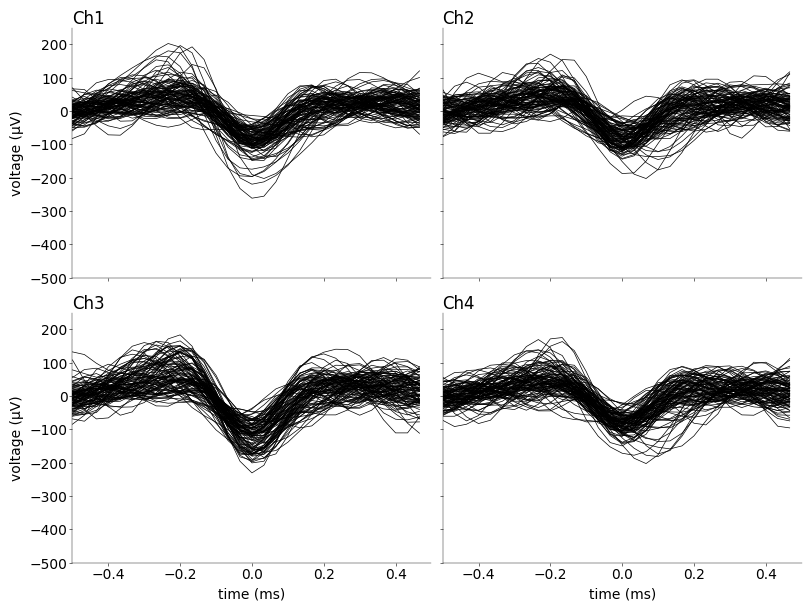

In [14]:
# ---------------------------------------------------------------------
# plot first and largest 100 spikes and answer the questions (1+1 pts)


mosaic = [
    ["Ch1", "Ch2"],
    ["Ch3", "Ch4"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# first 100 spikes

w_first = extract_waveforms(y.to_numpy(), s[:100])
t = np.arange(-0.0005, 0.0005, dt) * 1000  # time in ms

for i, ch in enumerate(cols):
    for waveform in w_first[:, :, i]:
        ax[ch].plot(t, waveform, color="black", lw=0.5)

# ---------------------------------------------------------------------

# cols = ["Ch1", "Ch2", "Ch3", "Ch4"]
for i, col in enumerate(cols):

    # labeling etc
    ax[col].set_ylim((-500, 250))
    ax[col].set_xlim((-0.5, 0.5))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (μV)")
    else:
        ax[col].set_yticklabels([])

Plot largest 100 spike waveforms

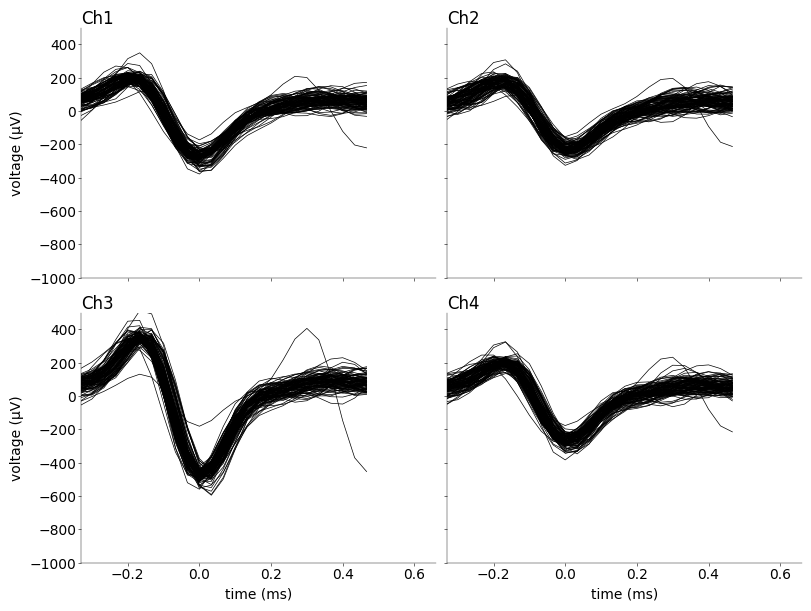

In [15]:
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 6), layout="constrained", dpi=100
)

# largest 100 spikes ----------------------------------------
w = extract_waveforms(y.to_numpy(), s)  # (n_spikes, window_len, n_channels)


# figure out for all spikes, which channel has the largest peak-to-peak amplitude for that spike
peak_amplitudes = np.max(w, axis=1) - np.min(w, axis=1)  # (n_spikes, n_channels)
dominant_channels = np.argmax(peak_amplitudes, axis=1)  # (n_spikes, )


# figure out from best channels per spike, which 100 spikes have the largest peak-to-peak amplitude
n_spikes = w.shape[0]
best_channel_waveforms = w[
    np.arange(n_spikes), :, dominant_channels
]  # (n_spikes, wiindow_len)

peak_amplitudes_best_channel = np.max(best_channel_waveforms, axis=1) - np.min(
    best_channel_waveforms, axis=1
)  # (n_spikes)

top_100_indices = np.argsort(peak_amplitudes_best_channel)[-100:][::-1]

w_large = extract_waveforms(y.to_numpy(), s[top_100_indices])


t = np.arange(-0.0005, 0.0005, dt) * 1000  # time in ms

for i, ch in enumerate(cols):
    for waveform in w_large[:, :, i]:
        ax[ch].plot(t, waveform, color="black", lw=0.5)

# ---------------------------------------------------------------------

for i, col in enumerate(cols):

    # labeling etc
    ax[col].set_ylim((-1000, 500))
    ax[col].set_xlim((-0.33, 0.66))
    ax[col].set_title(col, loc="left")
    if col == "Ch3" or col == "Ch4":
        ax[col].set_xlabel("time (ms)")
    else:
        ax[col].set_xticklabels([])
    if col == "Ch1" or col == "Ch3":
        ax[col].set_ylabel("voltage (μV)")
    else:
        ax[col].set_yticklabels([])

### Questions

1) Describe the shape of the spikes.

The waveforms all have a small positive inflection, and the larger negative deflection. For channel 3, the deflection (trough) is larger. 


1) Do the waveforms tend to be similar? If spikes have a similar waveform, what could that mean - and what does it mean if the waveforms look different?

If spikes have a similar waveform, they are likely belonging to the same neuron. 

## Task 4: Extract features using PCA
Compute the first three PCA features on each channel separately in ```extract_features()```. You can use a available PCA implementation or implement it yourself. After that, each spike is represented by a 12 element vector. Compute the fraction of variance captured by these three PCs. Also return the obtained parameters of the PCA

For one channel, plot the mean and the first three principal axes as calculated by the PCA in the feature space. Interprete them in light of the plots in the previous tasks.

For all pairwise combinations of channels, plot the resulting features of the 1st PCs as scatter plots against each other. Do you see clusters visually?

*Grading: 6 pts*

## PCA
### Questions (1 pt)
1) If we input the data from each channel separately to a PCA, what are the feature dimension of the input?

sklearn (n_samples, n_features) -> (n_spikes, length_window). The feature dimension is the voltage values over 1ms.

2) Therefore, what do the Principal Axes the PCA computes represent?

The PCA axes represents where in time, there will be the most voltage variations. 

3) Does it make sense to apply preprocessing steps, such as normalization? Have a look at the [scikit-learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). What is applied by default?

By default there is no pre-processing such as normalization. We could add z-normalization.

I assume `power_iteration_normalizer='auto` has nothing to do with data normalization, but instead with the eigenvector computation algorithm?

In [52]:
"""Solution"""


def extract_features(w: np.ndarray) -> np.ndarray:
    """Extract features for spike sorting from the waveforms w.

    Do PCA on the waveforms of each channel separately,
    then concatenate the first three principal components
    of each channels into one numpy array (`b`).


    Parameter
    ---------

    w: np.ndarray, (n_spikes, length_window, n_channels)
        Waveforms from Task 3.


    Return
    ------

    b: np.ndarray, (n_spikes, n_feature)
        the transformed data
    means: np.ndarray, (n_channels, length_window)
        means per channel
    principal_components: np.ndarray, (n_channels, 3, length_window)
        the 'principal axes' obtained by the pca


    Notes
    -----

    You can use PCA from sklearn.

    More on PCA
    https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html

    """
    # ----------------------------------------------
    # obtain first 3 principle components (1.5 pts)

    n_spikes, length_window, n_channels = w.shape
    pca = PCA(n_components=3)

    b = np.zeros((n_spikes, 3 * n_channels))  # (n_spikes, 12)
    means = np.zeros((n_channels, length_window))
    principal_components = np.zeros((n_channels, 3, length_window))

    for ch in range(n_channels):
        # sklearn (n_samples, n_features) -> (n_spikes, length_window)
        X = w[:, :, ch]

        # Mean waveform per channel
        means[ch] = np.mean(X, axis=0)

        pca.fit(X)
        b[:, ch * 3 : (ch + 1) * 3] = pca.transform(X)

        principal_components[ch] = pca.components_

        # ----------------------------------------------
        print(pca.explained_variance_ratio_)

        # -----------------------------------------------------------------------------------------------------
        # Print the fraction of variance explained by the three components combined for each channel (0.5 pts)
        print(
            f"Channel {ch + 1}: Variance explained by first 3 PCs: {np.sum(pca.explained_variance_ratio_):.2f}"
        )
        # -----------------------------------------------------------------------------------------------------

    return b, means, principal_components

In [53]:
b, means, principal_components = extract_features(w)

[0.39018869 0.17931135 0.10567831]
Channel 1: Variance explained by first 3 PCs: 0.68
[0.31898422 0.17065569 0.12250883]
Channel 2: Variance explained by first 3 PCs: 0.61
[0.36582252 0.16910436 0.12474038]
Channel 3: Variance explained by first 3 PCs: 0.66
[0.35340651 0.16276958 0.12517774]
Channel 4: Variance explained by first 3 PCs: 0.64


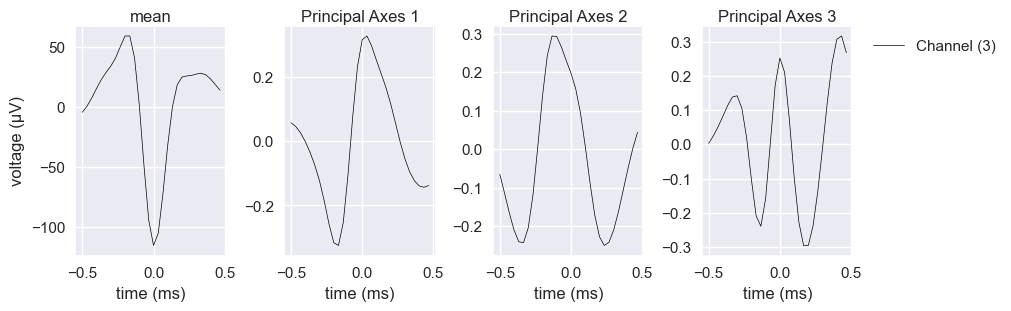

In [117]:
"""Solution"""

# ------------------------------------------------------------------------------------------------------------------
# Plot the mean of each channel and the three principal axes obtained by the PCA and answer the questions (1+1 pts)
# ------------------------------------------------------------------------------------------------------------------

mosaic = [
    ["mean", "Principal Axes 1", "Principal Axes 2", "Principal Axes 3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(10, 3), layout="constrained", dpi=100
)

t = np.arange(-0.0005, 0.0005, dt) * 1000  # time in ms

ch = 2  # channel to plot

ax["mean"].plot(t, means[ch, :], color="black", lw=0.5, label=mosaic[0][0])

for i, col in enumerate(mosaic[0][1:4]):
    ax[f"Principal Axes {i+1}"].plot(
        t, principal_components[ch, i, :], color="black", lw=0.5, label=col
    )


for channel in range(4):
    for i, mo in enumerate(np.ravel(mosaic)):

        ax[mo].set_xlabel("time (ms)")
        ax[mo].set_title(mo)

ax[mosaic[0][0]].set_ylabel("voltage (μV)")
ax[mosaic[0][-1]].legend(
    [f"Channel ({ch+1})"], loc="upper left", bbox_to_anchor=(1.04, 1)
)

plt.show()

### Questions

1) Compare the plot to the plots of the other tasks. What do you observe?

From the plot above in PC1 and PC2, I can see that eigenvalues are largest around 0ms, when the negative deflection in the waveform occurs (eigenvalues = how much the eigenvectors are stretched at different parts during the 1ms). 

2) What does the mean look like? Does this match your expectations?

PC1 and PC2 axis make sens (see answer below), but PC3 is harder to interpret. Given that it does not explain a lot of variance, I won't read too much into it. 

3) Explain what it means if a spike has a high value in the first dimension. What is the effect of the other dimensions?

From the pairwise distances between 1st PCs, we can see that especially the spikes detected in channel 3 are in a different cluster than spikes detected in the other channels. Going back to Task 2, 3, we saw that the peak-trough amplitude in channel 3 was much larger than for other channels. Likely the PC1 dimension captures variation in peak-trough amplitude in spike waveforms.

Text(0.5, 0.98, 'Pairwise 1st PCs')

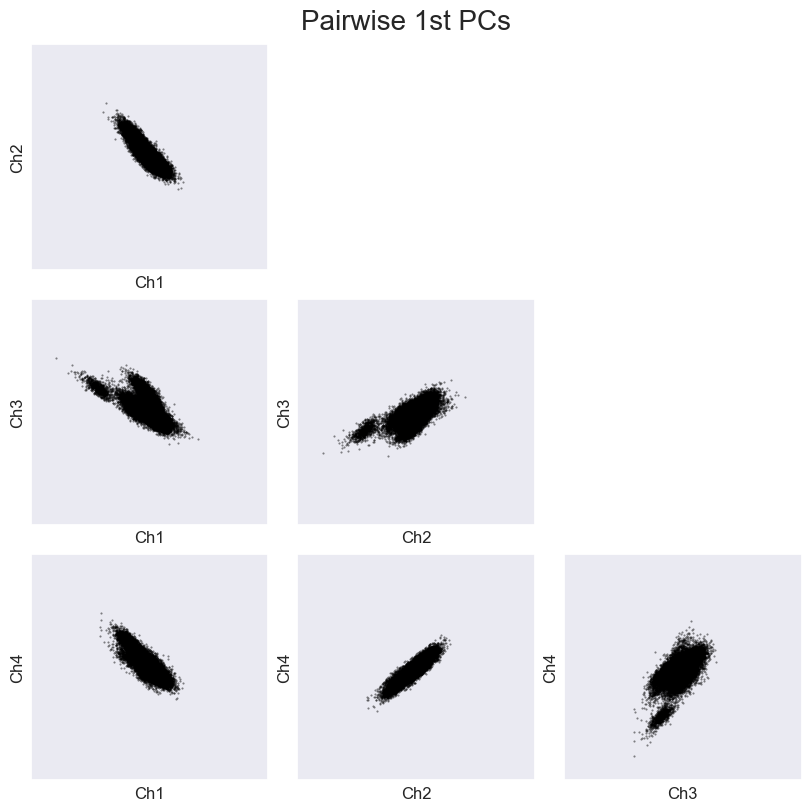

In [114]:
mosaic = [
    ["Ch2 vs Ch1", ".", "."],
    ["Ch3 vs Ch1", "Ch3 vs Ch2", "."],
    ["Ch4 vs Ch1", "Ch4 vs Ch2", "Ch4 vs Ch3"],
]
fig, ax = plt.subplot_mosaic(
    mosaic=mosaic, figsize=(8, 8), layout="constrained", dpi=100
)

# index of the 1st PC in `b`
i = {"Ch1": 0, "Ch2": 3, "Ch3": 6, "Ch4": 9}


# ----------------------------------------------------------------------------------------------------------
# Create a scatterplot of the projections of the spikes for all pairwise combinations of the 1st PCs (1 pt)

ax["Ch2 vs Ch1"].scatter(b[:, i["Ch2"]], b[:, i["Ch1"]], c="black", s=1, alpha=0.5)

ax["Ch3 vs Ch1"].scatter(b[:, i["Ch3"]], b[:, i["Ch1"]], c="black", s=1, alpha=0.5)

ax["Ch3 vs Ch2"].scatter(b[:, i["Ch3"]], b[:, i["Ch2"]], c="black", s=1, alpha=0.5)


ax["Ch4 vs Ch1"].scatter(b[:, i["Ch4"]], b[:, i["Ch1"]], c="black", s=1, alpha=0.5)


ax["Ch4 vs Ch2"].scatter(b[:, i["Ch4"]], b[:, i["Ch2"]], c="black", s=1, alpha=0.5)

ax["Ch4 vs Ch3"].scatter(b[:, i["Ch4"]], b[:, i["Ch3"]], c="black", s=1, alpha=0.5)


# ----------------------------------------------------------------------------------------------------------

for mo in np.ravel(mosaic):
    if mo == ".":
        continue
    y, x = mo.split(" vs ")

    ax[mo].set_xlabel(x)
    ax[mo].set_ylabel(y)
    ax[mo].set_xlim((-1500, 1500))
    ax[mo].set_ylim((-1500, 1500))
    ax[mo].set_xticks([])
    ax[mo].set_yticks([])

fig.suptitle("Pairwise 1st PCs", fontsize=20)

In [118]:
# save data for the next Coding Lab

np.save("../data/nds_cl_1_features", b)
np.save("../data/nds_cl_1_spiketimes_s", s)
np.save("../data/nds_cl_1_spiketimes_t", st)
np.save("../data/nds_cl_1_waveforms", w)